# Movies on internet platform analytics
The dataset is open on kaggle: https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney

In [1]:
# Start by importing our libraries

# Base libraries
import pandas as pd 
import numpy as np

# Processing and visualization
from sqlalchemy import create_engine # To use with pandas
import pandas_profiling # Data analytics visualization
from geopy.geocoders import Nominatim # To get geo position

# Plot libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
from matplotlib import cm
import geoviews as gv # Geo plotting
from geoviews import dim, opts
import geoviews.tile_sources as gvts
from bokeh.models import HoverTool # For the tooltip

# Other useful libraries
import os
import time
import operator
import random
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, OrderedDict

### Read the dataset

In [2]:
df = pd.read_csv('../data/MoviesOnStreamingPlatforms.csv', delimiter=',')
df.head()

Unnamed: 0  ID                           Title  Year  Age  IMDb  \
0           0   1                       Inception  2010  13+   8.8   
1           1   2                      The Matrix  1999  18+   8.7   
2           2   3          Avengers: Infinity War  2018  13+   8.5   
3           3   4              Back to the Future  1985   7+   8.5   
4           4   5  The Good, the Bad and the Ugly  1966  18+   8.8   

  Rotten Tomatoes  Netflix  Hulu  Prime Video  Disney+  Type  \
0             87%        1     0            0        0     0   
1             87%        1     0            0        0     0   
2             84%        1     0            0        0     0   
3             96%        1     0            0        0     0   
4             97%        1     0            1        0     0   

                        Directors                            Genres  \
0               Christopher Nolan  Action,Adventure,Sci-Fi,Thriller   
1  Lana Wachowski,Lilly Wachowski                     Action,Sci-Fi   
2         Anthony Russo,Joe Russo           Action,Adventure,Sci-Fi   
3                 Robert Zemeckis           Adventure,Comedy,Sci-Fi   
4                    Sergio Leone                           Western   

                        Country                 Language  Runtime  
0  United States,United Kingdom  English,Japanese,French    148.0  
1                 United States                  English    136.0  
2                 United States                  English    149.0  
3                 United States                  English    116.0  
4      Italy,Spain,West Germany                  Italian    161.0

### Let's use Pandas Profiling to get an high level view of our data

In [3]:
# Generating report
pandas_profiling.ProfileReport(df)

Senza dilungarci troppo, abbiamo ottenuto un sacco di informazioni:

* abbiamo 16744 istanze descritte da 17 attributi
* oltre agli ID, a noi superflui, abbiamo un attributo *type* con valore costante: ci conviene rimuoverlo
* vi sono molti missing value; in particolare Rotten Tomatoes presenta il 69.2% di missing value e anche Age raggiunge quota 56.1% (entrambi più della metà!)
* dato che l'attributo Title presenta valori univoci, eliminiamo gli ID e teniamo quello come identificativo
* abbiamo 3 tipologie di variabili: categoriche, numeriche e booleane

In [4]:
# Drop useless columns
df.drop(columns=['Unnamed: 0', 'ID', 'Type'], inplace=True)
df.head()

Title  Year  Age  IMDb Rotten Tomatoes  Netflix  \
0                       Inception  2010  13+   8.8             87%        1   
1                      The Matrix  1999  18+   8.7             87%        1   
2          Avengers: Infinity War  2018  13+   8.5             84%        1   
3              Back to the Future  1985   7+   8.5             96%        1   
4  The Good, the Bad and the Ugly  1966  18+   8.8             97%        1   

   Hulu  Prime Video  Disney+                       Directors  \
0     0            0        0               Christopher Nolan   
1     0            0        0  Lana Wachowski,Lilly Wachowski   
2     0            0        0         Anthony Russo,Joe Russo   
3     0            0        0                 Robert Zemeckis   
4     0            1        0                    Sergio Leone   

                             Genres                       Country  \
0  Action,Adventure,Sci-Fi,Thriller  United States,United Kingdom   
1                     Action,Sci-Fi                 United States   
2           Action,Adventure,Sci-Fi                 United States   
3           Adventure,Comedy,Sci-Fi                 United States   
4                           Western      Italy,Spain,West Germany   

                  Language  Runtime  
0  English,Japanese,French    148.0  
1                  English    136.0  
2                  English    149.0  
3                  English    116.0  
4                  Italian    161.0

Osserviamo nuovamente la matrice di correlazione.

In [5]:
# Correlation matrix
def correlationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

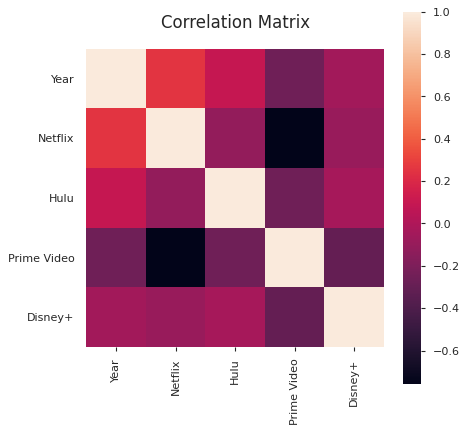

In [6]:
correlationMatrix(df, 6)

Risulta chiaro che **Netflix** contenga, almeno in questo dataset, film in media più recenti rispetto a tutti gli altri. Al contrario, **Prime Video** contiene film in media più vecchi.

### Sfruttiamo sqlalchemy per ottenere dal dataframe alcune informazioni in modo semplice:

In [7]:
engine = create_engine('sqlite:///:memory:')
df.to_sql('movies', engine)

pd.read_sql("SELECT MAX(movies.IMDb), title, year, country from movies;", engine)

MAX(movies.IMDb)                                              Title  Year  \
0               9.3  My Next Guest with David Letterman and Shah Ru...  2019   

  Country  
0    None

In [8]:
pd.read_sql("SELECT MIN(movies.IMDb), title, year, country from movies;", engine)

MIN(movies.IMDb)                 Title  Year      Country
0               0.0  9/11: 15 years later  2016  Netherlands

Vi è un film con valutazione 0.0 su IMDb, probabilmente un errore oppure generato da una totale assenza di voti. Il film con valutazione più alta invece è "My Next Guest". Osserviamo la piattaforma su cui è disponibile:

In [9]:
pd.read_sql("SELECT * from movies WHERE IMDb=9.3;", engine)

index                                              Title  Year   Age  IMDb  \
0   1292  My Next Guest with David Letterman and Shah Ru...  2019  None   9.3   
1   5110                                    Love on a Leash  2011  None   9.3   
2   6566                                         Square One  2019  None   9.3   
3   6837            Steven Banks: Home Entertainment Center  1989  None   9.3   
4   7220                                 Down, But Not Out!  2015  None   9.3   
5   7426                                             Bounty  2011  None   9.3   

  Rotten Tomatoes  Netflix  Hulu  Prime Video  Disney+         Directors  \
0            None        1     0            0        0              None   
1            None        0     0            1        0          Fen Tian   
2            None        0     0            1        0          Danny Wu   
3            None        0     0            1        0    Tom McLoughlin   
4            None        0     0            1        0  Miguel Gaudêncio   
5            None        0     0            1        0   Roger Donaldson   

                            Genres                                   Country  \
0                        Talk-Show                                      None   
1     Comedy,Drama,Fantasy,Romance                             United States   
2          Documentary,Drama,Music                             United States   
3                           Comedy                             United States   
4                Documentary,Sport                                    Poland   
5  Adventure,Drama,History,Romance  United Kingdom,United States,New Zealand   

  Language  Runtime  
0     None     61.0  
1     None     90.0  
2  English     83.0  
3  English     60.0  
4   Polish     68.0  
5  English    132.0

La query con Max o Min restituisce solo il primo valore: notiamo che ci sono 6 film con voto massimo (9.3). Di questi 6, solo il primo è su Netflix, gli altri sono tutti disponibili solo su Prime Video.
Osserviamo se ci sono altri film con valutazione nulla:

In [10]:
pd.read_sql("SELECT * from movies WHERE IMDb=0.0;", engine)

index                             Title  Year   Age  IMDb Rotten Tomatoes  \
0   4359              9/11: 15 years later  2016  None   0.0            None   
1  10613                           Capture  2018  None   0.0            None   
2  13813  In Memoriam Alexander Litvinenko  2007  None   0.0            None   
3  13821     From Philadelphia To Fallujah  2011  None   0.0            None   

   Netflix  Hulu  Prime Video  Disney+         Directors             Genres  \
0        0     1            0        0              None        Documentary   
1        0     0            1        0              None         Reality-TV   
2        0     0            1        0     Jos de Putter        Documentary   
3        0     0            1        0  David Hammelburg  Documentary,Short   

         Country Language  Runtime  
0    Netherlands  English     60.0  
1  United States  English     60.0  
2    Netherlands  English     55.0  
3  United States  English     42.0

Come ipotizzato, altri film hanno valutazione pari a 0.0, in particolare ben 4 film.

### Ok now let's start analyzing genres and countries.
We can see that each row is described by one or more genre and by one or more country.

### We make the decision to split into dummy vectors these attributes:

In [11]:
# Genres
separated_genres = df['Genres'].str.get_dummies(',')
separated_genres

Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0           1          1          0          0       0      0            0   
1           1          0          0          0       0      0            0   
2           1          1          0          0       0      0            0   
3           0          1          0          0       1      0            0   
4           0          0          0          0       0      0            0   
...       ...        ...        ...        ...     ...    ...          ...   
16739       0          0          0          0       1      0            0   
16740       0          0          0          0       1      0            0   
16741       0          0          0          0       0      0            1   
16742       0          0          0          0       0      0            1   
16743       0          0          0          0       0      0            1   

       Drama  Family  Fantasy  ...  News  Reality-TV  Romance  Sci-Fi  Short  \
0          0       0        0  ...     0           0        0       1      0   
1          0       0        0  ...     0           0        0       1      0   
2          0       0        0  ...     0           0        0       1      0   
3          0       0        0  ...     0           0        0       1      0   
4          0       0        0  ...     0           0        0       0      0   
...      ...     ...      ...  ...   ...         ...      ...     ...    ...   
16739      0       1        1  ...     0           0        0       0      0   
16740      0       1        0  ...     0           0        0       1      0   
16741      0       0        0  ...     0           0        0       0      0   
16742      0       0        0  ...     0           0        0       0      0   
16743      0       1        0  ...     0           0        0       0      1   

       Sport  Talk-Show  Thriller  War  Western  
0          0          0         1    0        0  
1          0          0         0    0        0  
2          0          0         0    0        0  
3          0          0         0    0        0  
4          0          0         0    0        1  
...      ...        ...       ...  ...      ...  
16739      0          0         0    0        0  
16740      0          0         0    0        0  
16741      0          0         0    0        0  
16742      0          0         0    0        0  
16743      0          0         0    0        0  

[16744 rows x 27 columns]

In [12]:
separated_countries = df['Country'].str.get_dummies(',')
separated_countries

Afghanistan  Albania  Algeria  Angola  Argentina  Armenia  Aruba  \
0                0        0        0       0          0        0      0   
1                0        0        0       0          0        0      0   
2                0        0        0       0          0        0      0   
3                0        0        0       0          0        0      0   
4                0        0        0       0          0        0      0   
...            ...      ...      ...     ...        ...      ...    ...   
16739            0        0        0       0          0        0      0   
16740            0        0        0       0          0        0      0   
16741            0        0        0       0          0        0      0   
16742            0        0        0       0          0        0      0   
16743            0        0        0       0          0        0      0   

       Australia  Austria  Azerbaijan  ...  United States  Uruguay  Vanuatu  \
0              0        0           0  ...              1        0        0   
1              0        0           0  ...              1        0        0   
2              0        0           0  ...              1        0        0   
3              0        0           0  ...              1        0        0   
4              0        0           0  ...              0        0        0   
...          ...      ...         ...  ...            ...      ...      ...   
16739          0        0           0  ...              1        0        0   
16740          0        0           0  ...              1        0        0   
16741          0        0           0  ...              1        0        0   
16742          0        0           0  ...              1        0        0   
16743          0        0           0  ...              1        0        0   

       Venezuela  Vietnam  West Germany  Yemen  Yugoslavia  Zambia  Zimbabwe  
0              0        0             0      0           0       0         0  
1              0        0             0      0           0       0         0  
2              0        0             0      0           0       0         0  
3              0        0             0      0           0       0         0  
4              0        0             1      0           0       0         0  
...          ...      ...           ...    ...         ...     ...       ...  
16739          0        0             0      0           0       0         0  
16740          0        0             0      0           0       0         0  
16741          0        0             0      0           0       0         0  
16742          0        0             0      0           0       0         0  
16743          0        0             0      0           0       0         0  

[16744 rows x 168 columns]

### What we can see now is that we have 27 different genres and 168 different countries. 
### Visualize most popular countries and genres.

<BarContainer object of 10 artists>

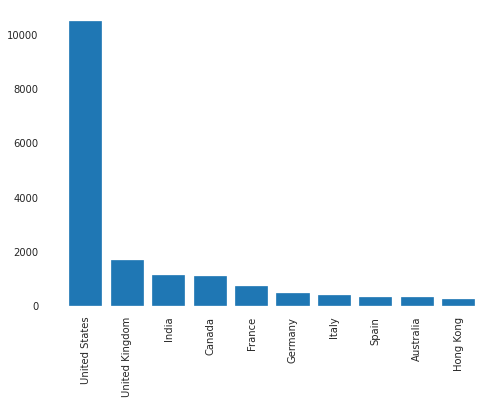

In [13]:
countries = separated_countries.columns
count_countries = defaultdict(lambda: 0)
for c in countries:
    count_countries[c] = separated_countries[c].value_counts()[1]

# Now order by max values
count_countries = {k: v for k, v in sorted(count_countries.items(), key=lambda item: item[1], reverse=True)}

plt.xticks(rotation = 90)
plt.bar(list(count_countries.keys())[:10], list(count_countries.values())[:10])

<BarContainer object of 10 artists>

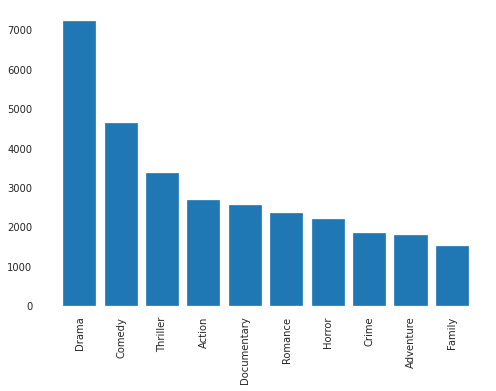

In [14]:
# Now repeat for genres
genres = separated_genres.columns
count_genres = defaultdict(lambda: 0)
for g in genres:
    count_genres[g] = separated_genres[g].value_counts()[1]

# Now order by max values
count_genres = {k: v for k, v in sorted(count_genres.items(), key=lambda item: item[1], reverse=True)}

plt.xticks(rotation = 90)
plt.bar(list(count_genres.keys())[:10], list(count_genres.values())[:10])

### Now we will create a single dataframe and a dict containing all the information we need to analyze genres and locations.

In [15]:
dataset = pd.concat([separated_countries, separated_genres], axis = 1, sort = False)
dataset.head()

Afghanistan  Albania  Algeria  Angola  Argentina  Armenia  Aruba  \
0            0        0        0       0          0        0      0   
1            0        0        0       0          0        0      0   
2            0        0        0       0          0        0      0   
3            0        0        0       0          0        0      0   
4            0        0        0       0          0        0      0   

   Australia  Austria  Azerbaijan  ...  News  Reality-TV  Romance  Sci-Fi  \
0          0        0           0  ...     0           0        0       1   
1          0        0           0  ...     0           0        0       1   
2          0        0           0  ...     0           0        0       1   
3          0        0           0  ...     0           0        0       1   
4          0        0           0  ...     0           0        0       0   

   Short  Sport  Talk-Show  Thriller  War  Western  
0      0      0          0         1    0        0  
1      0      0          0         0    0        0  
2      0      0          0         0    0        0  
3      0      0          0         0    0        0  
4      0      0          0         0    0        1  

[5 rows x 195 columns]

In [16]:
map_col = dataset.columns
map_dict = defaultdict(lambda: {})

genres = separated_genres.columns
countries = separated_countries.columns

# We want country name as key
for c in countries:
    map_dict[c]['n_films'] = separated_countries[c].value_counts()[1]
    map_dict[c]['genres'] = []
    # Iterate the dataframe and append genres, then we will filter the list with counts
    for i, v in dataset.iterrows():
        if v[c]==1:
            temp_genres = []
            for g in genres:
                if v[g]==1:
                    temp_genres.append(g)
                    map_dict[c]['genres'].append(g)

map_dict

defaultdict(<function __main__.<lambda>()>,
            {'Afghanistan': {'n_films': 4,
              'genres': ['Action',
               'Documentary',
               'History',
               'War',
               'Documentary',
               'History',
               'War',
               'Drama',
               'Documentary',
               'History',
               'War']},
             'Albania': {'n_films': 5,
              'genres': ['Drama',
               'Crime',
               'Drama',
               'Thriller',
               'Drama',
               'Documentary',
               'Drama']},
             'Algeria': {'n_films': 4,
              'genres': ['Drama',
               'Mystery',
               'Drama',
               'Biography',
               'Drama',
               'Drama']},
             'Angola': {'n_films': 1, 'genres': ['Documentary']},
             'Argentina': {'n_films': 106,
              'genres': ['Comedy',
               'Drama',
               'Biogr

In [17]:
# Now count genres
for key, value in map_dict.items():
    temp_set = set(value['genres'])
    value['n_genres'] = {}
    for g in temp_set:
        value['n_genres'][g] = value['genres'].count(g)
        
# Now delete genres list from dict and rename n_genres to genres
for key, value in map_dict.items():
    del value['genres']
    value['genres'] = value.pop('n_genres')
map_dict

defaultdict(<function __main__.<lambda>()>,
            {'Afghanistan': {'n_films': 4,
              'genres': {'Drama': 1,
               'War': 3,
               'History': 3,
               'Action': 1,
               'Documentary': 3}},
             'Albania': {'n_films': 5,
              'genres': {'Drama': 4,
               'Documentary': 1,
               'Thriller': 1,
               'Crime': 1}},
             'Algeria': {'n_films': 4,
              'genres': {'Drama': 4, 'Biography': 1, 'Mystery': 1}},
             'Angola': {'n_films': 1, 'genres': {'Documentary': 1}},
             'Argentina': {'n_films': 106,
              'genres': {'Family': 5,
               'Sport': 4,
               'Horror': 7,
               'Sci-Fi': 1,
               'Comedy': 27,
               'Thriller': 21,
               'Biography': 12,
               'History': 6,
               'War': 2,
               'Short': 1,
               'Musical': 2,
               'News': 1,
               'Fantas

Define a function to get latitude and longitude according to country names

In [18]:
geolocator = Nominatim(user_agent="movies_analytics")

def geolocate(country=None):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude 
        return (float(loc.latitude), float(loc.longitude))
    # Otherwise
    except:
        # Return missing value
        print(f'missing ...{country}')
        return np.nan

In [19]:
# Add latitude and longitude to our dict
for key, value in map_dict.items():
    if key.lower() == 'federal republic of yugoslavia':
        lat, lon = geolocate(country='yugoslavia')
    elif key.lower() == 'holy see (vatican city state)':
        lat, lon = geolocate(country='vatican city')
    else:
        lat, lon = geolocate(country=key.lower())
    value['position'] = {}
    value['position']['latitude'] = lat
    value['position']['longitude'] = lon
    time.sleep(0.2)
map_dict

defaultdict(<function __main__.<lambda>()>,
            {'Afghanistan': {'n_films': 4,
              'genres': {'Drama': 1,
               'War': 3,
               'History': 3,
               'Action': 1,
               'Documentary': 3},
              'position': {'latitude': 33.7680065, 'longitude': 66.2385139}},
             'Albania': {'n_films': 5,
              'genres': {'Drama': 4,
               'Documentary': 1,
               'Thriller': 1,
               'Crime': 1},
              'position': {'latitude': 41.000028, 'longitude': 19.9999619}},
             'Algeria': {'n_films': 4,
              'genres': {'Drama': 4, 'Biography': 1, 'Mystery': 1},
              'position': {'latitude': 28.0000272, 'longitude': 2.9999825}},
             'Angola': {'n_films': 1,
              'genres': {'Documentary': 1},
              'position': {'latitude': -11.8775768, 'longitude': 17.5691241}},
             'Argentina': {'n_films': 106,
              'genres': {'Family': 5,
            

### Start visualizing using maps 

In [20]:
# Define a simple dataframe
dominant_genre = []
lats = []
lons = []
films = []
countries = []

for k, v in map_dict.items():
    lats.append(v['position']['latitude'])
    lons.append(v['position']['longitude'])
    films.append(v['n_films'])
    countries.append(k)
    dominant_genre.append(max(v['genres'].items(), key=operator.itemgetter(1))[0])

temp = {'Country': countries, 'Latitude': lats, 'Longitude': lons, 'Films': films, 'Dominant_Genre': dominant_genre}
simple_df = pd.DataFrame(data=temp)

In [21]:
# We want colours now, one for each genre
colors = []
for g in genres:
    colors.append("#%06x" % random.randint(0, 0xFFFFFF))
    
colors_df = []
for i, v in simple_df.iterrows():
    g = v['Dominant_Genre']
    index = list(genres).index(g)
    colors_df.append(colors[index])

simple_df['Colors'] = colors_df
simple_df.head()

Country   Latitude  Longitude  Films Dominant_Genre   Colors
0  Afghanistan  33.768006  66.238514      4            War  #cebce8
1      Albania  41.000028  19.999962      5          Drama  #15059c
2      Algeria  28.000027   2.999983      4          Drama  #15059c
3       Angola -11.877577  17.569124      1    Documentary  #2368d0
4    Argentina -34.996496 -64.967282    106          Drama  #15059c

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
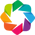

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Country,Films,Dominant_Genre,Colors)

In [22]:
# Define points and background, then visualize
gv.extension('bokeh')

tooltips = [('Films', '@Films'),
            ('Dominant Genre', '@Dominant_Genre'),
            ('Country', '@Country'),
            ]
hover = HoverTool(tooltips=tooltips)

gv_points = gv.Points(simple_df, ['Longitude', 'Latitude'], ['Country', 'Films', 'Dominant_Genre', 'Colors'])

plot = (gvts.CartoLight * gv_points).opts(
    opts.Points(width=900, height=700, alpha=0.3, hover_line_color='black',
                color=dim('Colors'), line_color='black', xaxis=None, yaxis=None,
                tools=[hover], size=np.sqrt(dim('Films'))*2))
plot

As we had already noticed, Drama genre and United States are dominant.

## Now we can investigate which genre is more popular in each platform

Netflix has 3650 films, Hulu 903, Prime Video 12354 and Disney+ 564.

The most popular platform in this dataset is Prime Video.

To see the most popular genre in each platform, we have to extract 4 different dataframes, one for each platform with value = 1. 

In [23]:
# Create a new dataframe with original data and dummy data about genres
merge = [df, separated_genres]
new_df = pd.concat(merge, axis=1)
new_df.head()

Title  Year  Age  IMDb Rotten Tomatoes  Netflix  \
0                       Inception  2010  13+   8.8             87%        1   
1                      The Matrix  1999  18+   8.7             87%        1   
2          Avengers: Infinity War  2018  13+   8.5             84%        1   
3              Back to the Future  1985   7+   8.5             96%        1   
4  The Good, the Bad and the Ugly  1966  18+   8.8             97%        1   

   Hulu  Prime Video  Disney+                       Directors  ... News  \
0     0            0        0               Christopher Nolan  ...    0   
1     0            0        0  Lana Wachowski,Lilly Wachowski  ...    0   
2     0            0        0         Anthony Russo,Joe Russo  ...    0   
3     0            0        0                 Robert Zemeckis  ...    0   
4     0            1        0                    Sergio Leone  ...    0   

  Reality-TV Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
0          0       0       1      0      0          0         1    0        0  
1          0       0       1      0      0          0         0    0        0  
2          0       0       1      0      0          0         0    0        0  
3          0       0       1      0      0          0         0    0        0  
4          0       0       0      0      0          0         0    0        1  

[5 rows x 41 columns]

In [24]:
# Let's use sqlalchemy to extract the dataframes we need
new_df.to_sql('platforms', engine)
netflix = pd.read_sql("SELECT * from platforms WHERE Netflix=1;", engine)
hulu = pd.read_sql("SELECT * from platforms WHERE Hulu=1;", engine)
prime = pd.read_sql("SELECT * from platforms WHERE [Prime Video]=1;", engine)
disney = pd.read_sql("SELECT * from platforms WHERE [Disney+]=1;", engine)

In [25]:
# Let's print one of them
netflix.head()

index                           Title  Year  Age  IMDb Rotten Tomatoes  \
0      0                       Inception  2010  13+   8.8             87%   
1      1                      The Matrix  1999  18+   8.7             87%   
2      2          Avengers: Infinity War  2018  13+   8.5             84%   
3      3              Back to the Future  1985   7+   8.5             96%   
4      4  The Good, the Bad and the Ugly  1966  18+   8.8             97%   

   Netflix  Hulu  Prime Video  Disney+  ... News Reality-TV Romance Sci-Fi  \
0        1     0            0        0  ...    0          0       0      1   
1        1     0            0        0  ...    0          0       0      1   
2        1     0            0        0  ...    0          0       0      1   
3        1     0            0        0  ...    0          0       0      1   
4        1     0            1        0  ...    0          0       0      0   

   Short  Sport  Talk-Show  Thriller  War  Western  
0      0      0          0         1    0        0  
1      0      0          0         0    0        0  
2      0      0          0         0    0        0  
3      0      0          0         0    0        0  
4      0      0          0         0    0        1  

[5 rows x 42 columns]

In [26]:
# Read once again genres names
genres = separated_genres.columns

# Iterate genres and count their values. Save then in a dict
genres_count = {'netflix': {}, 'hulu': {}, 'prime': {}, 'disney': {}}
for g in genres:
        genres_count['netflix'][g] = netflix[g].value_counts()
        genres_count['hulu'][g] = hulu[g].value_counts()
        genres_count['prime'][g] = prime[g].value_counts()
        genres_count['disney'][g] = disney[g].value_counts()

genres_count

{'netflix': {'Action': 0    3015
  1     545
  Name: Action, dtype: int64,
  'Adventure': 0    3242
  1     318
  Name: Adventure, dtype: int64,
  'Animation': 0    3338
  1     222
  Name: Animation, dtype: int64,
  'Biography': 0    3361
  1     199
  Name: Biography, dtype: int64,
  'Comedy': 0    2252
  1    1308
  Name: Comedy, dtype: int64,
  'Crime': 0    3188
  1     372
  Name: Crime, dtype: int64,
  'Documentary': 0    3049
  1     511
  Name: Documentary, dtype: int64,
  'Drama': 0    2059
  1    1501
  Name: Drama, dtype: int64,
  'Family': 0    3245
  1     315
  Name: Family, dtype: int64,
  'Fantasy': 0    3302
  1     258
  Name: Fantasy, dtype: int64,
  'Film-Noir': 0    3559
  1       1
  Name: Film-Noir, dtype: int64,
  'Game-Show': 0    3559
  1       1
  Name: Game-Show, dtype: int64,
  'History': 0    3428
  1     132
  Name: History, dtype: int64,
  'Horror': 0    3294
  1     266
  Name: Horror, dtype: int64,
  'Music': 0    3428
  1     132
  Name: Music, dtype

In [27]:
# We want only the count of value=1
for g in genres:
    for platform in ['netflix', 'hulu', 'prime', 'disney']:
        try:
            genres_count[platform][g] = genres_count[platform][g].values[1]
        except:
            genres_count[platform][g] = 0

<BarContainer object of 10 artists>

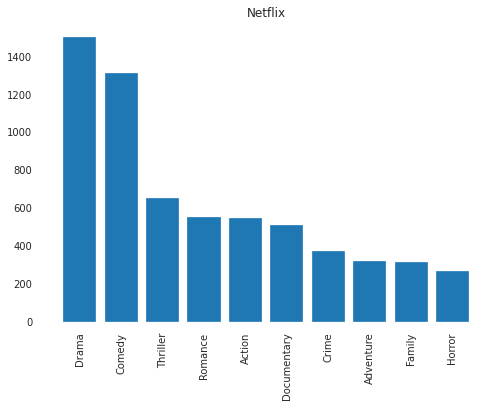

In [28]:
# Let's order by value and then plot the 10 most popular
for platform in ['netflix', 'hulu', 'prime', 'disney']:
    genres_count[platform] = {k: v for k, v in sorted(genres_count[platform].items(), key=lambda item: item[1], reverse=True)}
    
# Plot
plt.title('Netflix')
plt.xticks(rotation = 90)
plt.bar(list(genres_count['netflix'].keys())[:10], list(genres_count['netflix'].values())[:10])

<BarContainer object of 10 artists>

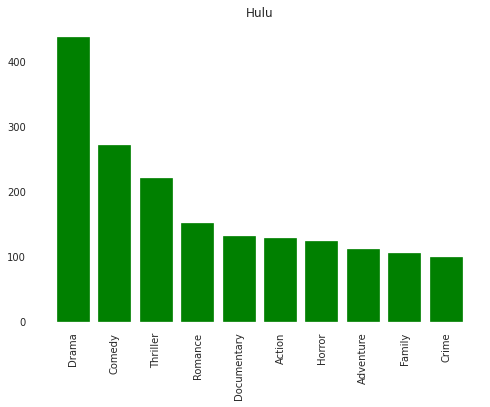

In [29]:
plt.title('Hulu')
plt.xticks(rotation = 90)
plt.bar(list(genres_count['hulu'].keys())[:10], list(genres_count['hulu'].values())[:10], color='green')

<BarContainer object of 10 artists>

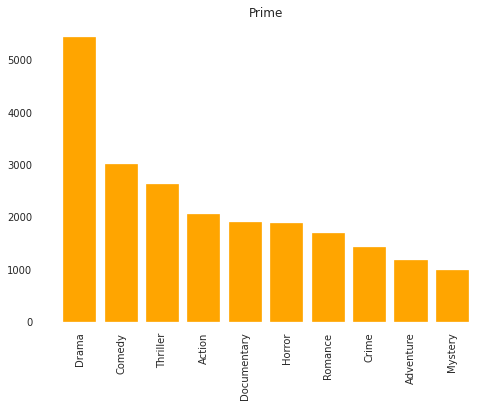

In [30]:
plt.title('Prime')
plt.xticks(rotation = 90)
plt.bar(list(genres_count['prime'].keys())[:10], list(genres_count['prime'].values())[:10], color='orange')

<BarContainer object of 10 artists>

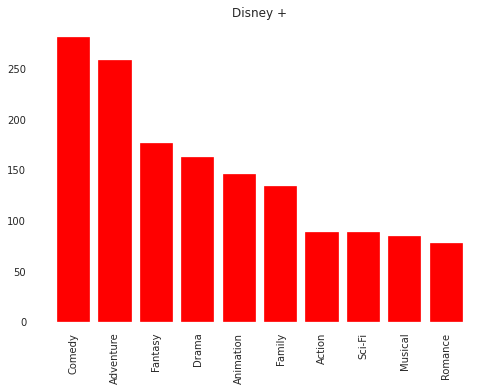

In [31]:
plt.title('Disney +')
plt.xticks(rotation = 90)
plt.bar(list(genres_count['disney'].keys())[:10], list(genres_count['disney'].values())[:10], color='red')

As we had already seen, Drama is the dominant genre among all the platform but Disney+, which is a platform for young people. Disney+ indeed provides a lot of comedy and adventure.

The second most popular genre is comedy in the other 3 platforms.

### Let's see if popularity is directly proportional to average IMDb scores!
In order to do so, let's select all most popular genre and compute an average of idmb column, excluding outsiders with value=0.0 which could be an error (we have already talked about that problem).

In [32]:
# Top 3 genres are: Drama, Comedy and Thriller.
filter_zeros = pd.read_sql("SELECT * from platforms WHERE not IMDb=0.0;", engine)

print(filter_zeros.groupby('Drama').mean()['IMDb'])
print('\n',filter_zeros.groupby('Comedy').mean()['IMDb'])
print('\n',filter_zeros.groupby('Thriller').mean()['IMDb'])

Drama
0    5.769137
1    6.075494
Name: IMDb, dtype: float64

 Comedy
0    5.903676
1    5.905568
Name: IMDb, dtype: float64

 Thriller
0    6.046608
1    5.352066
Name: IMDb, dtype: float64


We are interested in the row starting with "1", which means the value of the genre. As we can see, the higher the popularity, the higher the average vote and therefore if we could define a new attribute called genre-popularity, it probably would be directly proportional to IMDb scores.

Visualize these analysis on top 10 genres in a bi-dimensional plot.

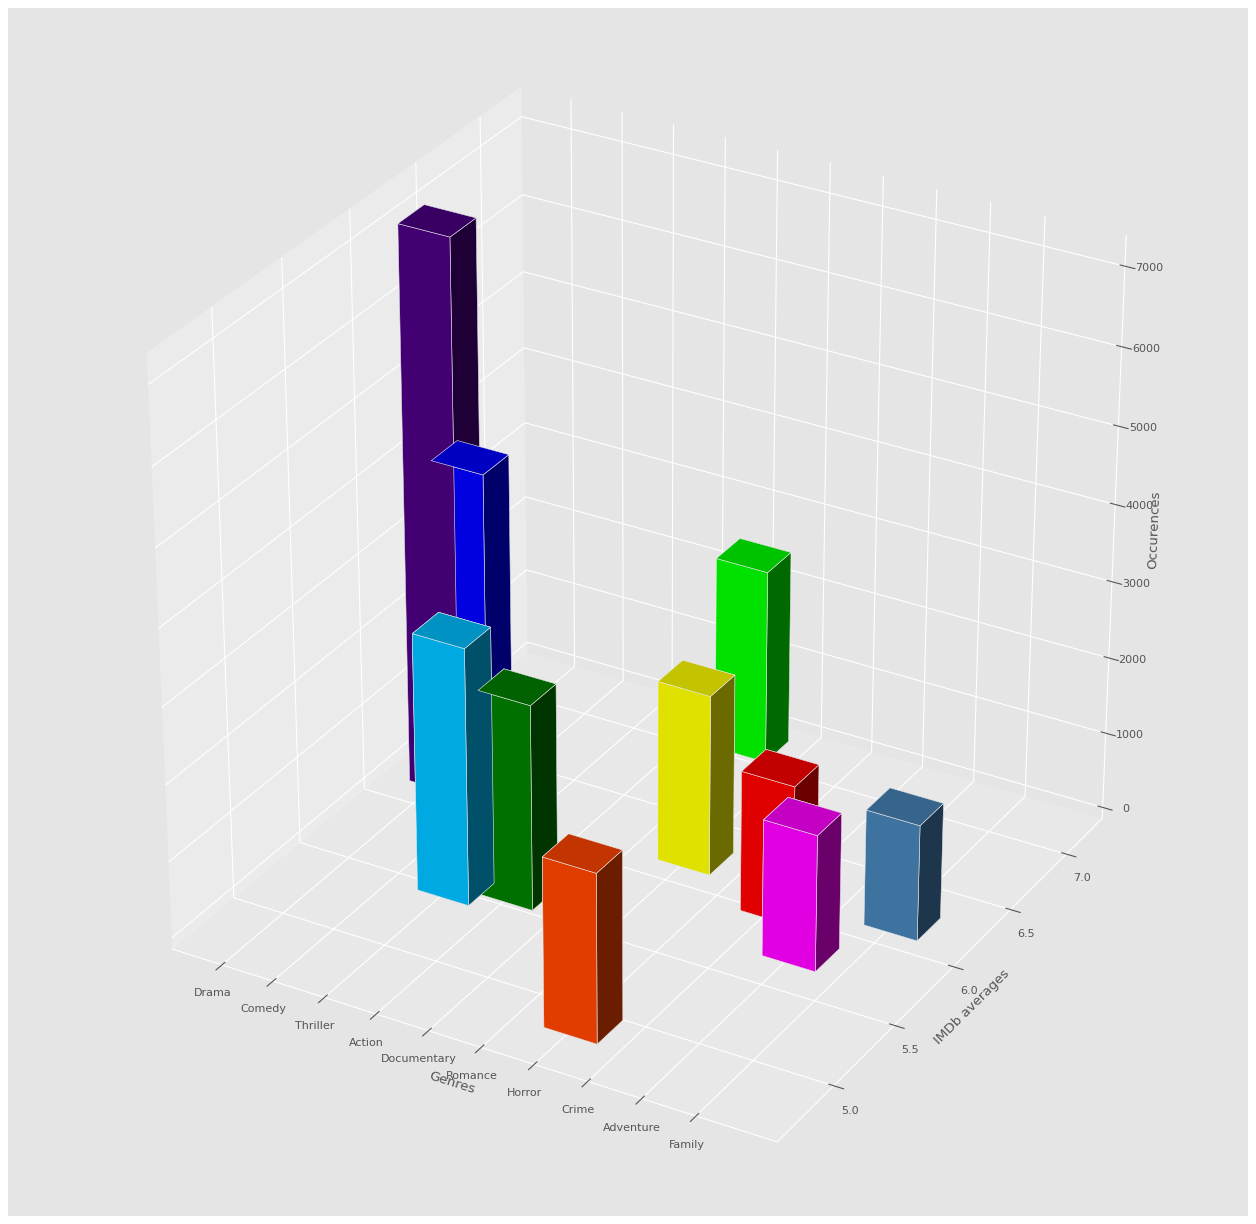

In [33]:
# Save average votes and count
genres_2d = dict()
for g in genres:
    genres_2d[g] = dict()
    genres_2d[g]['count'] = separated_genres[g].value_counts()[1]
    genres_2d[g]['imdb'] = filter_zeros.groupby(g).mean()['IMDb'][1]

# Order by count value
genres_2d = {k: v for k, v in sorted(genres_2d.items(), key=lambda item: item[1]['count'], reverse=True)}

# Now save 3 lists
genre_names = list(genres_2d.keys())
genre_count = []
genre_vote = []
for k, v in genres_2d.items():
    genre_vote.append(v['imdb'])
    genre_count.append(v['count'])

style.use('ggplot')

fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111, projection='3d')

dx = np.ones(10)
dy = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]
dz = np.zeros(10)

colors = ['indigo', 'b', 'deepskyblue', 'g', 'lime', 'yellow', 'orangered', 'r', 'magenta', 'steelblue']

x_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

xpos = np.arange(np.array(genre_names[:10]).shape[0])

ax.bar3d(np.array([i for i in range(10)]), np.array(genre_vote[:10]), dz, dx, dy, np.array(genre_count[:10]), color=colors)

ax.w_xaxis.set_ticks(xpos + 0.5/2.)
ax.w_xaxis.set_ticklabels(np.array(genre_names))

ax.set_xlabel('Genres')
ax.set_ylabel('IMDb averages')
ax.set_zlabel('Occurences')

plt.show()

We can clearly see an exception in our previsions: Documentary genre has the highest average IMDb vote. Except this, the other genres are described by lower votes than top2.

We can also see that in top10 genres, almost all genres have average votes near 6. Horror is the genre with the lowest average vote among top10, but we could expect this result knowing that horror movies are very criticized, since it is difficult to scary everyone and provide a good plot.

Before going into the next analysis, let's check out the actual value of Documentary genre.

In [34]:
print(filter_zeros.groupby('Documentary').mean()['IMDb'])

Documentary
0    5.722941
1    6.951341
Name: IMDb, dtype: float64


Indeed, with 6.9 average vote, Documentary is surely appreciated.

## Now we would like to analyze how many films are multi-platform

In [35]:
# Just extract a subset of the df with platform attributs and count the number of 1.
# If the number of ones are > 1, then that film is multi-platform.
platform_df = df[['Netflix', 'Hulu', 'Prime Video', 'Disney+']]
count_platforms = (platform_df == 1).astype(int).sum(axis=1)
index = 0
multiplatform = dict()
for row in count_platforms:
    if row > 1:
        multiplatform[index] = row
    if row == 4:
        # All platforms!
        print('All 4 platforms film: ',df.iloc[index]['Title'])
    index += 1 

In [36]:
print('Number of multi-platform films: ',len(multiplatform))
print('Max number of platforms where a film is stored: ',max(multiplatform.items(), key=operator.itemgetter(1))[1])

print('These films are :')
count = 0
for k, v in multiplatform.items():
    if v == max(multiplatform.items(), key=operator.itemgetter(1))[1]:
        count += 1
        print('\t- ', df.iloc[k]['Title'])
print(f'For a total of {count} films on {max(multiplatform.items(), key=operator.itemgetter(1))[1]} platforms.')


Number of multi-platform films:  627
Max number of platforms where a film is stored:  3
These films are :
	-  Amy
	-  The Square
	-  The Interview
	-  Blame!
	-  Evolution
	-  No Game No Life: Zero
	-  Zapped
	-  Mother
	-  The Kid
	-  Inside Out
For a total of 10 films on 3 platforms.


So, 627 out of 16744 films are multiplatform. 626 of these are reproduced on 2 out of 4 platform, only 10 films are available on 3 platforms and no film is available on all the platforms.

## Finally, let's analyze age constraints in films and which platform provides more 18+ content.
According to what we have seen in our profiling report, Age attribute has 5 possible values:
* **18+**: 3474 records
* **7+**: 1462 records
* **13+**: 1255 records
* **all**: 843 records
* **16+**: 320 records
* **Missing values**: 9390

We can imagine that 7+ should belong to Disney+ platform, but what about 13+, 16+ and 18+ distribution?

In [37]:
eighteen = pd.read_sql("SELECT * from movies WHERE Age='18+';", engine)
print('Netflix has '+str(eighteen['Netflix'].value_counts()[1])+' 18+ films')
print('Hulu has '+str(eighteen['Hulu'].value_counts()[1])+' 18+ films')
print('Prime Video has '+str(eighteen['Prime Video'].value_counts()[1])+' 18+ films')
print('Disney+ has '+str(eighteen['Disney+'].value_counts()[1])+' 18+ films')
print('\n\n')

sixteen = pd.read_sql("SELECT * from movies WHERE Age='16+';", engine)
print('Netflix has '+str(sixteen['Netflix'].value_counts()[1])+' 16+ films')
print('Hulu has '+str(sixteen['Hulu'].value_counts()[1])+' 16+ films')
print('Prime Video has '+str(sixteen['Prime Video'].value_counts()[1])+' 16+ films')
print('Disney+ has '+str(sixteen['Disney+'].value_counts()[1])+' 16+ films')
print('\n\n')

thirteen = pd.read_sql("SELECT * from movies WHERE Age='13+';", engine)
print('Netflix has '+str(thirteen['Netflix'].value_counts()[1])+' 13+ films')
print('Hulu has '+str(thirteen['Hulu'].value_counts()[1])+' 13+ films')
print('Prime Video has '+str(thirteen['Prime Video'].value_counts()[1])+' 13+ films')
print('Disney+ has '+str(thirteen['Disney+'].value_counts()[1])+' 13+ films')
print('\n\n')

seven = pd.read_sql("SELECT * from movies WHERE Age='7+';", engine)
print('Netflix has '+str(seven['Netflix'].value_counts()[1])+' 7+ films')
print('Hulu has '+str(seven['Hulu'].value_counts()[1])+' 7+ films')
print('Prime Video has '+str(seven['Prime Video'].value_counts()[1])+' 7+ films')
print('Disney+ has '+str(seven['Disney+'].value_counts()[1])+' 7+ films')

Netflix has 752 18+ films
Hulu has 290 18+ films
Prime Video has 2612 18+ films
Disney+ has 3 18+ films



Netflix has 89 16+ films
Hulu has 17 16+ films
Prime Video has 226 16+ films
Disney+ has 1 16+ films



Netflix has 383 13+ films
Hulu has 119 13+ films
Prime Video has 819 13+ films
Disney+ has 40 13+ films



Netflix has 323 7+ films
Hulu has 109 7+ films
Prime Video has 916 7+ films
Disney+ has 179 7+ films


Ok, results showed are not very descriptive, since we should normalize with the number of film the platform provides. Let's normalize then and visualize results:

In [38]:
# We know already that Netflix has 3560 films, Hulu 903, Prime Video 12354 and Disney+ 564.

print('Netflix has '+str(eighteen['Netflix'].value_counts()[1]/3560)+' 18+ films normalized over 3560')
print('Hulu has '+str(eighteen['Hulu'].value_counts()[1]/903)+' 18+ films normalized over 903')
print('Prime Video has '+str(eighteen['Prime Video'].value_counts()[1]/12354)+' 18+ films normalized over 12354')
print('Disney+ has '+str(eighteen['Disney+'].value_counts()[1]/564)+' 18+ films normalized over 564')
print('\n\n')

print('Netflix has '+str(sixteen['Netflix'].value_counts()[1]/3560)+' 16+ films normalized over 3560')
print('Hulu has '+str(sixteen['Hulu'].value_counts()[1]/903)+' 16+ films normalized over 903')
print('Prime Video has '+str(sixteen['Prime Video'].value_counts()[1]/12354)+' 16+ films normalized over 12354')
print('Disney+ has '+str(sixteen['Disney+'].value_counts()[1]/564)+' 16+ films normalized over 564')
print('\n\n')

print('Netflix has '+str(thirteen['Netflix'].value_counts()[1]/3560)+' 13+ films normalized over 3560')
print('Hulu has '+str(thirteen['Hulu'].value_counts()[1]/903)+' 13+ films normalized over 903')
print('Prime Video has '+str(thirteen['Prime Video'].value_counts()[1]/12354)+' 13+ films normalized over 12354')
print('Disney+ has '+str(thirteen['Disney+'].value_counts()[1]/564)+' 13+ films normalized over 564')
print('\n\n')

print('Netflix has '+str(seven['Netflix'].value_counts()[1]/3560)+' 7+ films normalized over 3560')
print('Hulu has '+str(seven['Hulu'].value_counts()[1]/903)+' 7+ films normalized over 903')
print('Prime Video has '+str(seven['Prime Video'].value_counts()[1]/12354)+' 7+ films normalized over 12354')
print('Disney+ has '+str(seven['Disney+'].value_counts()[1]/564)+' 7+ films normalized over 564')
print('\n\n')

Netflix has 0.21123595505617979 18+ films normalized over 3560
Hulu has 0.3211517165005537 18+ films normalized over 903
Prime Video has 0.21142949651934595 18+ films normalized over 12354
Disney+ has 0.005319148936170213 18+ films normalized over 564



Netflix has 0.025 16+ films normalized over 3560
Hulu has 0.018826135105204873 16+ films normalized over 903
Prime Video has 0.018293670066375264 16+ films normalized over 12354
Disney+ has 0.0017730496453900709 16+ films normalized over 564



Netflix has 0.10758426966292135 13+ films normalized over 3560
Hulu has 0.13178294573643412 13+ films normalized over 903
Prime Video has 0.06629431762991743 13+ films normalized over 12354
Disney+ has 0.07092198581560284 13+ films normalized over 564



Netflix has 0.09073033707865169 7+ films normalized over 3560
Hulu has 0.12070874861572536 7+ films normalized over 903
Prime Video has 0.07414602557875992 7+ films normalized over 12354
Disney+ has 0.3173758865248227 7+ films normalized over 56

Ok, after these less clear numbers, we can see ratios about number of film with a certain age restriction on the number of films that are available the paltform. We can see that Hulu has the highest 18+ ratio, while Prime and Netflix are a lot close and obviously Disney+ has the lowest ratio.

Considering 16+ restriction, Netflix is the platform that provide the most films among the 4 we have. Hulu is the first even considering 13+ restriction and obviuosly Disney+ is the best kids show provider.

Concluding this section, let's visualize 18+ films on Disney+.

In [39]:
eighteen[eighteen['Disney+']==1]

index     Title  Year  Age  IMDb Rotten Tomatoes  Netflix  Hulu  \
50      103       Amy  2015  18+   7.8             95%        1     0   
926    3960   The Kid  2019  18+   5.9             45%        0     1   
2712  11538  The Swap  1979  18+   3.4            None        0     0   

      Prime Video  Disney+          Directors                   Genres  \
50              1        1               None                    Drama   
926             1        1  Vincent D'Onofrio  Biography,Drama,Western   
2712            1        1          Jay Karas    Comedy,Family,Fantasy   

            Country Language  Runtime  
50    United States  English     60.0  
926   United States  English    100.0  
2712  United States  English    100.0

So, 2 out the 10 films 3-platforms are 18+ from Disney+.

## There are yet a lot of analytics to perform on this dataset: i'll continue soon!